In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.preprocessing import LabelEncoder


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


Data Preprocessing


In [2]:
train_data=pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
train_data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [3]:
test_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
test_data.head()

,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400


In [4]:
train_data.describe()

,id,Open,Close,Volume
count,300.000000,300.000000,300.000000,3.000000e+02
mean,149.500000,75.977813,79.430489,1.866300e+08
std,86.746758,16.158343,13.878395,7.952792e+07
min,0.000000,40.269435,47.979353,5.991330e+07
25%,74.750000,64.872395,69.689227,1.324862e+08
50%,149.500000,79.805683,82.991900,1.715536e+08
75%,224.250000,88.342927,89.719145,2.201842e+08
max,299.000000,102.558322,103.119373,6.935702e+08


In [5]:
train_data.info

<bound method DataFrame.info of       id        Date       Open      Close     Volume Strategy
0      0  2015-06-01  66.208486  75.609978  298506300     Hold
1      1  2015-06-08  64.116235  74.443331  227974800     Hold
2      2  2015-06-15  47.701942  71.140831  250670900      Buy
3      3  2015-06-22  54.754816  72.881344  223614300     Hold
4      4  2015-06-29  48.031899  66.284718  406814900      Buy
..   ...         ...        ...        ...        ...      ...
295  295  2021-01-25  81.284821  83.373498  117281600     Sell
296  296  2021-02-01  71.970249  85.294903  177655800     Sell
297  297  2021-02-08  71.784627  83.266453  146003500     Hold
298  298  2021-02-15  69.372333  81.026827  167762500     Hold
299  299  2021-02-22  69.618620  78.672007  332979200     Hold

[300 rows x 6 columns]>

In [6]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy
...,...,...,...,...,...,...
295,295,2021-01-25,81.284821,83.373498,117281600,Sell
296,296,2021-02-01,71.970249,85.294903,177655800,Sell
297,297,2021-02-08,71.784627,83.266453,146003500,Hold
298,298,2021-02-15,69.372333,81.026827,167762500,Hold


Missing Data

In [7]:
missing_data = train_data.isna().sum()
print(missing_data)


id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64


In [8]:
missing_data = test_data.isna().sum()
print(missing_data)

id        0
Date      0
Open      0
Volume    0
dtype: int64


In [9]:
def check_missing_values(df):
    nan_count = df.isna().sum().sum()
    empty_string_count = (df == '').sum().sum()
    double_space_count = (df == '  ').sum().sum()

    missing_data_summary = pd.DataFrame({
        'NaN': [nan_count],
        'Empty String': [empty_string_count],
        'Double Space': [double_space_count]
    })

    return missing_data_summary

In [10]:
check_missing_values(train_data)

,NaN,Empty String,Double Space
0,0,0,0


In [11]:
check_missing_values(test_data)

,NaN,Empty String,Double Space
0,0,0,0


Outliers check

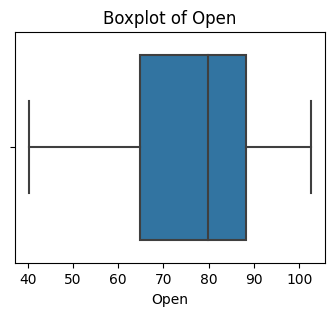

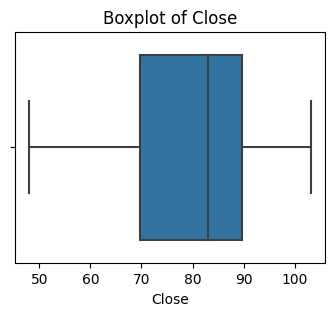

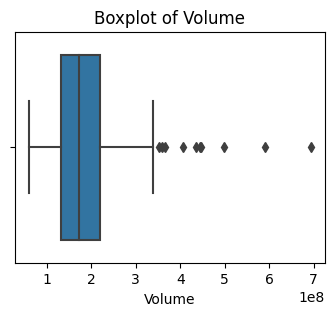

In [12]:
columns_to_check = ['Open', 'Close','Volume']

for column in columns_to_check:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x=train_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [13]:
z_score_threshold = 7
for column in columns_to_check:
    z_scores = (train_data[column] - train_data[column].mean()) / train_data[column].std()
    train_data = train_data[abs(z_scores) <= z_score_threshold]


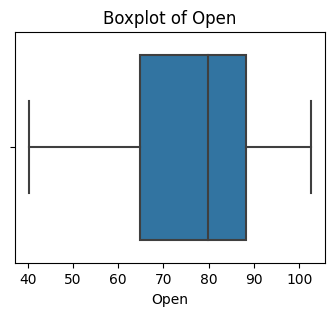

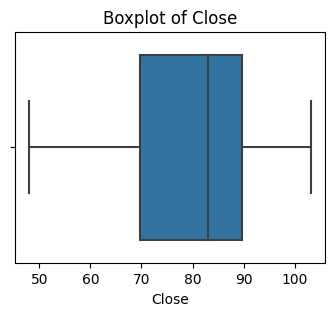

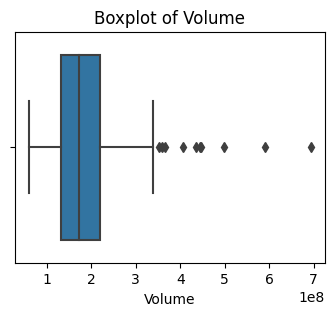

In [14]:
columns_to_check = ['Open', 'Close','Volume']

for column in columns_to_check:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x=train_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

Anomalies

In [15]:
anomalies = []

for column in columns_to_check:
    z_scores = np.abs(stats.zscore(train_data[column]))
    column_anomalies = train_data[np.abs(z_scores) > z_score_threshold]
    anomalies.append(column_anomalies)

# Print or explore the detected anomalies
for i, column_anomalies in enumerate(anomalies):
    if not column_anomalies.empty:
        print(f"Anomalies in {numerical_columns[i]}:")
        print(column_anomalies)

In [16]:
column_anomalies

,id,Date,Open,Close,Volume,Strategy


Data Visualization

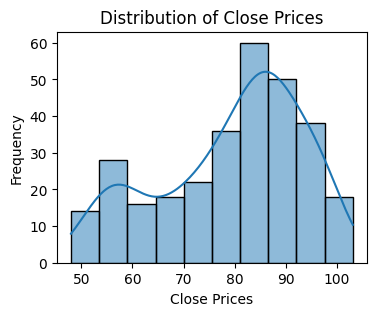

Skewness: -0.5608305379154453
Kurtosis: -0.7079542537881989


In [17]:
plt.figure(figsize=(4, 3))
sns.histplot(train_data['Close'], kde=True)
plt.title('Distribution of Close Prices')
plt.xlabel('Close Prices')
plt.ylabel('Frequency')
plt.show()

skewness = train_data['Close'].skew()
kurtosis = train_data['Close'].kurtosis()
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

In [18]:
train_data['Strategy_Buy'] = (train_data['Strategy'] == 'Buy').astype(int)
train_data['Strategy_Hold'] = (train_data['Strategy'] == 'Hold').astype(int)
train_data['Strategy_Sell'] = (train_data['Strategy'] == 'Sell').astype(int)

# Drop the original 'Strategy' column
train_data = train_data.drop(columns=['Strategy'])
train_data

,id,Date,Open,Close,Volume,Strategy_Buy,Strategy_Hold,Strategy_Sell
0,0,2015-06-01,66.208486,75.609978,298506300,0,1,0
1,1,2015-06-08,64.116235,74.443331,227974800,0,1,0
2,2,2015-06-15,47.701942,71.140831,250670900,1,0,0
3,3,2015-06-22,54.754816,72.881344,223614300,0,1,0
4,4,2015-06-29,48.031899,66.284718,406814900,1,0,0
...,...,...,...,...,...,...,...,...
295,295,2021-01-25,81.284821,83.373498,117281600,0,0,1
296,296,2021-02-01,71.970249,85.294903,177655800,0,0,1
297,297,2021-02-08,71.784627,83.266453,146003500,0,1,0
298,298,2021-02-15,69.372333,81.026827,167762500,0,1,0


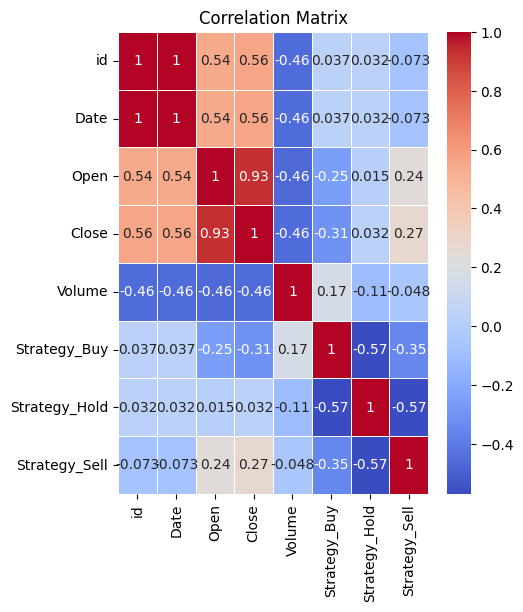

In [19]:
correlation_matrix = train_data.corr()

plt.figure(figsize=(5, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

time-series-plot

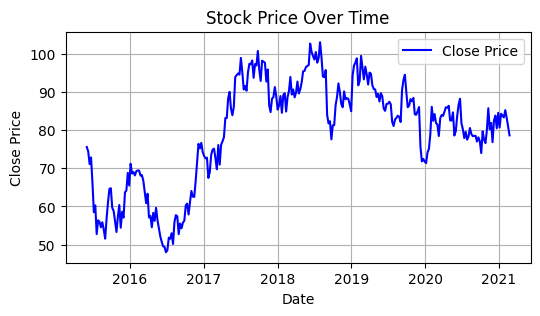

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', color='blue')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


   
  Moving Average Plot

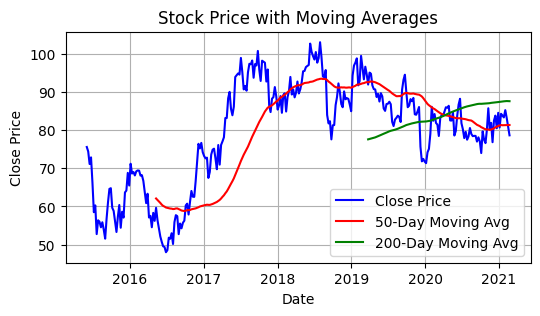

In [21]:
plt.figure(figsize=(6, 3))
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', color='blue')
plt.plot(train_data['Date'], train_data['Close'].rolling(window=50).mean(), label='50-Day Moving Avg', color='red')
plt.plot(train_data['Date'], train_data['Close'].rolling(window=200).mean(), label='200-Day Moving Avg', color='green')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Volume analysis

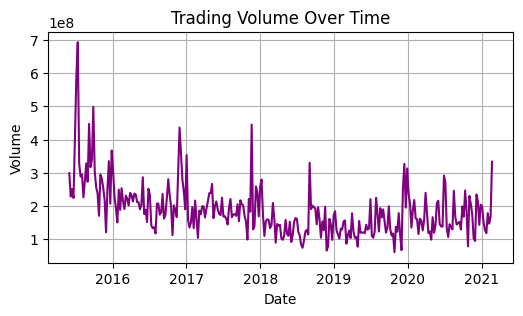

In [22]:
plt.figure(figsize=(6, 3))
plt.plot(train_data['Date'], train_data['Volume'], label='Trading Volume', color='purple')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()


Bollinger Bands Plot

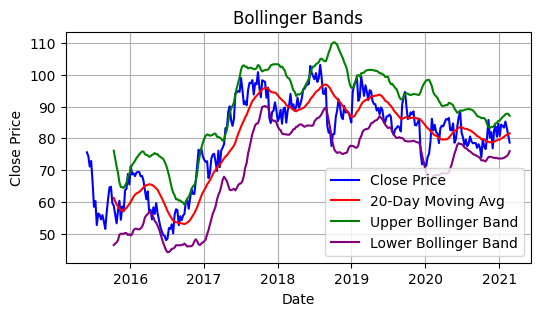

In [23]:
plt.figure(figsize=(6, 3))
plt.plot(train_data['Date'], train_data['Close'], label='Close Price', color='blue')
plt.plot(train_data['Date'], train_data['Close'].rolling(window=20).mean(), label='20-Day Moving Avg', color='red')
plt.plot(train_data['Date'], train_data['Close'].rolling(window=20).mean() + 2 * train_data['Close'].rolling(window=20).std(), label='Upper Bollinger Band', color='green')
plt.plot(train_data['Date'], train_data['Close'].rolling(window=20).mean() - 2 * train_data['Close'].rolling(window=20).std(), label='Lower Bollinger Band', color='purple')
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


Price volume relationship

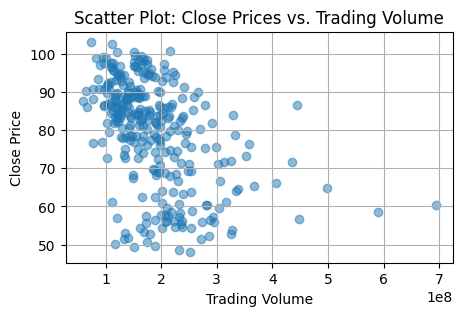

In [24]:
plt.figure(figsize=(5, 3))
plt.scatter(train_data['Volume'], train_data['Close'], alpha=0.5)
plt.title('Scatter Plot: Close Prices vs. Trading Volume')
plt.xlabel('Trading Volume')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

Distribution Analysis

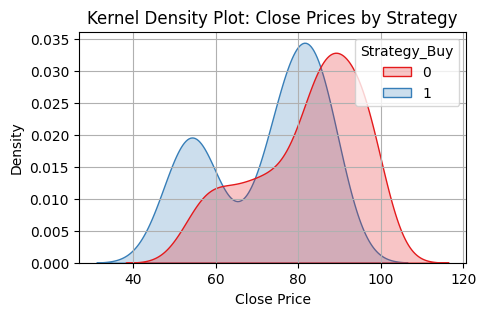

In [25]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=train_data, x='Close', hue='Strategy_Buy', fill=True, common_norm=False, palette='Set1')
plt.title('Kernel Density Plot: Close Prices by Strategy')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.grid(True)
plt.show()

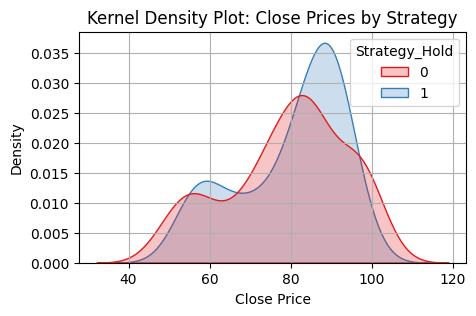

In [26]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=train_data, x='Close', hue='Strategy_Hold', fill=True, common_norm=False, palette='Set1')
plt.title('Kernel Density Plot: Close Prices by Strategy')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.grid(True)
plt.show()

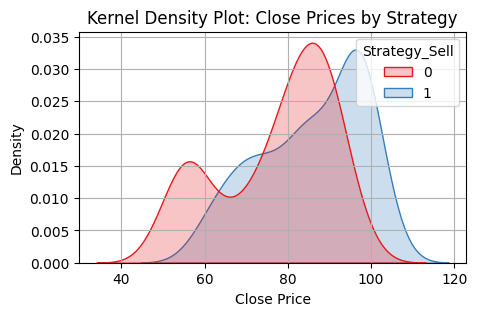

In [27]:
plt.figure(figsize=(5, 3))
sns.kdeplot(data=train_data, x='Close', hue='Strategy_Sell', fill=True, common_norm=False, palette='Set1')
plt.title('Kernel Density Plot: Close Prices by Strategy')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.grid(True)
plt.show()

MODEL

In [28]:
train_data.set_index('Date', inplace=True)

In [29]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
adf_result = adfuller(train_data['Close'])

# Check and print ADF test results
if adf_result[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)")


The time series is non-stationary (fail to reject the null hypothesis)


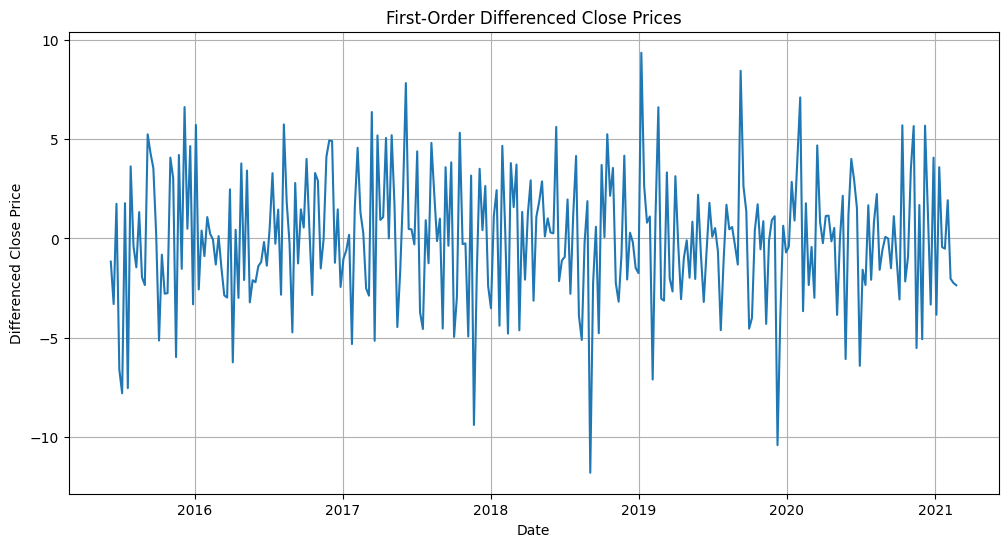

In [30]:

train_data['Close_diff'] = train_data['Close'] - train_data['Close'].shift(1)
train_data.dropna(inplace=True)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_data['Close_diff'])
plt.title('First-Order Differenced Close Prices')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.grid(True)
plt.show()

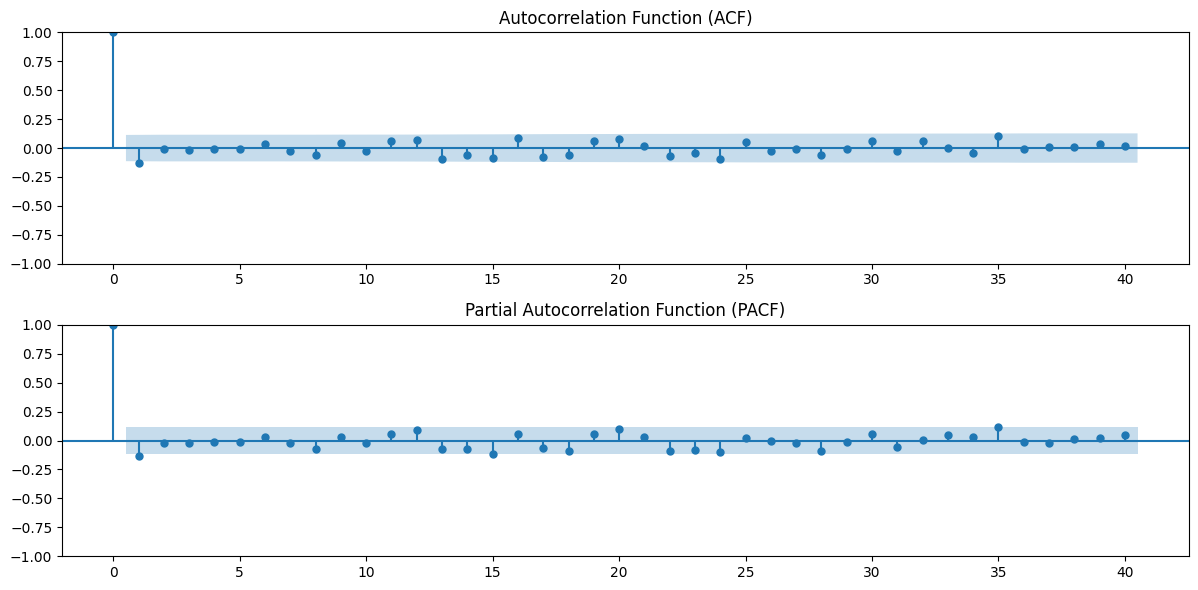

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Create ACF and PACF plots
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(train_data['Close_diff'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(2, 1, 2)
plot_pacf(train_data['Close_diff'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


SARIMA

In [32]:
# Convert 'Date' to datetime
#train_data['Date'] = pd.to_datetime(train_df['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set 'Date' as the index
#train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)


In [33]:

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.2 * len(train_data))

# Split the data into training and validation sets
train_set = train_data.iloc[:-validation_size]
validation_set = train_data.iloc[-validation_size:]

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA order and seasonal order
p, d, q = 1, 1, 2  # You can adjust these parameters
P, D, Q, s = 1, 1, 1, 4  # You can adjust these parameters

# Create and fit the SARIMA model on the training data
sarima_model = SARIMAX(train_data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit = sarima_model.fit(disp=False)

# Forecast on the validation set
forecast = sarima_fit.forecast(steps=len(validation_set))

# Evaluate the model using SMAPE
smape = np.mean(np.abs(forecast - validation_set) / (np.abs(forecast) + np.abs(validation_set)))


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [35]:
smape

nan

<!-- import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load your data and preprocess it as before
# Define the size of the validation set (e.g., 20%)
validation_size = int(0.2 * len(train_set))

# Split the data into training and validation sets
train_data = train_set.iloc[:-validation_size]
validation_data = train_set.iloc[-validation_size:]

# Define features and target variable
X_train = train_data.drop(['Close'], axis=1)
y_train = train_data['Close']
X_valid = validation_data.drop(['Close'], axis=1)
y_valid = validation_data['Close']

# Create and train a Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = random_forest_model.predict(X_valid)

# Evaluate the Random Forest model using Mean Absolute Error (MAE) or other metrics
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
 -->

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load your data and preprocess it as before

# Define the size of the validation set (e.g., 20%)
validation_size = int(0.2 * len(train_set))

# Split the data into training and validation sets
train_data = train_set.iloc[:-validation_size]
validation_data = train_set.iloc[-validation_size:]

# Define features and target variable
X_train = train_data.drop(['Close'], axis=1)
y_train = train_data['Close']
X_valid = validation_data.drop(['Close'], axis=1)
y_valid = validation_data['Close']

# Create and train a Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = random_forest_model.predict(X_valid)

smape = np.mean(2 * np.abs(y_pred - y_valid) / (np.abs(y_pred) + np.abs(y_valid)))

print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")


Symmetric Mean Absolute Percentage Error (SMAPE): 0.04%


In [37]:
forecast = sarima_fit.forecast(steps=len(test_data))


In [38]:
forecast = sarima_fit.forecast(steps=len(test_data))
print(forecast)

2021-03-01    79.403165
2021-03-08    79.126067
2021-03-15    79.075182
2021-03-22    79.104784
2021-03-29    79.529391
                ...    
2022-12-26    77.909079
2023-01-02    78.298086
2023-01-09    77.964797
2023-01-16    77.859172
2023-01-23    77.836423
Freq: W-MON, Name: predicted_mean, Length: 100, dtype: float64


In [39]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Load your data and preprocess it as before

# # Define the size of the validation set (e.g., 20%)
# validation_size = int(0.2 * len(train_set))

# # Split the data into training and validation sets
# train_data = train_set.iloc[:-validation_size]
# validation_data = train_set.iloc[-validation_size:]

# # Define features and target variable
# X_train = train_data.drop(['Close'], axis=1)
# y_train = train_data['Close']
# X_valid = validation_data.drop(['Close'], axis=1)
# y_valid = validation_data['Close']

# # Create and train a KNN model
# knn_model = KNeighborsRegressor(n_neighbors=3)
# knn_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = knn_model.predict(X_valid)

# smape = np.mean(2 * np.abs(y_pred - y_valid) / (np.abs(y_pred) + np.abs(y_valid)))

# print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")


In [40]:
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Load your data and preprocess it as before

# # Define the size of the validation set (e.g., 20%)
# validation_size = int(0.2 * len(train_set))

# # Split the data into training and validation sets
# train_data = train_set.iloc[:-validation_size]
# validation_data = train_set.iloc[-validation_size:]

# # Define features and target variable
# X_train = train_data.drop(['Close'], axis=1)
# y_train = train_data['Close']
# X_valid = validation_data.drop(['Close'], axis=1)
# y_valid = validation_data['Close']

# # Create and train an SVM model
# svm_model = SVR(kernel='linear')
# svm_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = svm_model.predict(X_valid)

# smape = np.mean(2 * np.abs(y_pred - y_valid) / (np.abs(y_pred) + np.abs(y_valid)))

# print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")


In [41]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # Load your data and preprocess it as before

# # Define the size of the validation set (e.g., 20%)
# validation_size = int(0.2 * len(train_set))

# # Split the data into training and validation sets
# train_data = train_set.iloc[:-validation_size]
# validation_data = a.iloc[-validation_size:]

# # Define features and target variable
# X_train = train_data.drop(['Close'], axis=1)
# y_train = train_data['Close']
# X_valid = validation_data.drop(['Close'], axis=1)
# y_valid = validation_data['Close']

# # Create and train a Decision Tree model
# decision_tree_model = DecisionTreeRegressor()
# decision_tree_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred = decision_tree_model.predict(X_valid)


# smape = np.mean(2 * np.abs(y_pred - y_valid) / (np.abs(y_pred) + np.abs(y_valid)))

# print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder 
# Load your training data (train.csv)
train_data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
# Convert 'Date' to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])
#test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set 'Date' as the index
#train_data.set_index('Date', inplace=True)
#test_data.set_index('Date', inplace=True)

# Encode the 'Strategy' column to convert categorical values to numerical values
strategy_encoder = LabelEncoder()
train_data['Strategy_encoded'] = strategy_encoder.fit_transform(train_data['Strategy'])

# Define features and targets
X = train_data[['Open', 'Volume']]
y_close = train_data['Close']
y_strategy = train_data['Strategy_encoded']  # Now using the encoded column

# Split the data into training and testing sets
X_train, X_test, y_close_train, y_close_test, y_strategy_train, y_strategy_test = train_test_split(
    X, y_close, y_strategy, test_size=0.2, random_state=42)

# Create and train the XGBoost model for closing price prediction
close_model = xgb.XGBRegressor()
close_model.fit(X_train, y_close_train)

# Make closing price predictions
y_close_pred = close_model.predict(X_test)

# Create and train the XGBoost model for strategy recommendation
strategy_model = xgb.XGBClassifier()
strategy_model.fit(X_train, y_strategy_train)

# Make strategy recommendations
y_strategy_pred = strategy_model.predict(X_test)

# Evaluate the models
smape = np.mean(np.abs(y_close_pred - y_close_test) / (np.abs(y_close_pred) + np.abs(y_close_test))) * 100

# Calculate Accuracy for Strategy
accuracy_strategy = accuracy_score(y_strategy_test, y_strategy_pred) * 100
loss_metric = 1 - (accuracy_strategy / 100)

print(f"SMAPE for Close Price: {smape:.2f}%")
print(f"Accuracy for Strategy: {accuracy_strategy:.2f}%")
print(f"Loss Metric for Strategy: {loss_metric:.2f}")

# Load your test data (test.csv)
test_data = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
# Convert 'Date' to datetime
#train_data['Date'] = pd.to_datetime(train_df['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set 'Date' as the index
#train_data.set_index('Date', inplace=True)
#test_data.set_index('Date', inplace=True)

# Make predictions on the test data
test_features = test_data[['Open', 'Volume']]
close_price_predictions = close_model.predict(test_features)
strategy_recommendations_encoded = strategy_model.predict(test_features)

# Inverse transform the encoded recommendations to get the original labels
strategy_recommendations = strategy_encoder.inverse_transform(strategy_recommendations_encoded)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Date': test_data['Date'],
    'Close': close_price_predictions,
    'Strategy': strategy_recommendations
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

SMAPE for Close Price: 2.92%
Accuracy for Strategy: 43.33%
Loss Metric for Strategy: 0.57


In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load your training data (train.csv)
train_data = pd.read_csv('/kaggle/input/ue21cs342aa2/train.csv')
# Convert 'Date' to datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

# Encode the 'Strategy' column to convert categorical values to numerical values
strategy_encoder = LabelEncoder()
train_data['Strategy_encoded'] = strategy_encoder.fit_transform(train_data['Strategy'])

# Define features and targets
X = train_data[['Open', 'Volume']]
y_close = train_data['Close']
y_strategy = train_data['Strategy_encoded']

# Split the data into training and testing sets
X_train, X_test, y_close_train, y_close_test, y_strategy_train, y_strategy_test = train_test_split(
    X, y_close, y_strategy, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost models
param_grid_close = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
param_grid_strategy = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Create and train the XGBoost model for closing price prediction with hyperparameter tuning
close_model = xgb.XGBRegressor()
close_grid_search = GridSearchCV(close_model, param_grid=param_grid_close, cv=3)
close_grid_search.fit(X_train, y_close_train)

# Get the best hyperparameters for the closing price model
best_close_model = close_grid_search.best_estimator_

# Make closing price predictions
y_close_pred = best_close_model.predict(X_test)

# Create and train the XGBoost model for strategy recommendation with hyperparameter tuning
strategy_model = xgb.XGBClassifier()
strategy_grid_search = GridSearchCV(strategy_model, param_grid=param_grid_strategy, cv=3)
strategy_grid_search.fit(X_train, y_strategy_train)

# Get the best hyperparameters for the strategy model
best_strategy_model = strategy_grid_search.best_estimator_

# Make strategy recommendations
y_strategy_pred = best_strategy_model.predict(X_test)

# Evaluate the models
smape = np.mean(np.abs(y_close_pred - y_close_test) / (np.abs(y_close_pred) + np.abs(y_close_test))) * 100
accuracy_strategy = accuracy_score(y_strategy_test, y_strategy_pred) * 100
loss_metric = 1 - (accuracy_strategy / 100)

print(f"SMAPE for Close Price: {smape:.2f}%")
print(f"Accuracy for Strategy: {accuracy_strategy:.2f}%")
print(f"Loss Metric for Strategy: {loss_metric:.2f}")

# Load your test data (test.csv)
test_data = pd.read_csv('/kaggle/input/ue21cs342aa2/test.csv')
# Convert 'Date' to datetime
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Make predictions on the test data
test_features = test_data[['Open', 'Volume']]
close_price_predictions = best_close_model.predict(test_features)
strategy_recommendations_encoded = best_strategy_model.predict(test_features)

# Inverse transform the encoded recommendations to get the original labels
strategy_recommendations = strategy_encoder.inverse_transform(strategy_recommendations_encoded)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Date': test_data['Date'],
    'Close': close_price_predictions,
    'Strategy': strategy_recommendations
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)


SMAPE for Close Price: 2.81%
Accuracy for Strategy: 45.00%
Loss Metric for Strategy: 0.55


In [44]:
# import pandas as pd
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# training_data = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
# testing_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")

# training_data['Date'] = pd.to_datetime(training_data['Date'])
# testing_data['Date'] = pd.to_datetime(testing_data['Date'])

# def add_features(df):
#     df['SMA_20'] = df['Open'].rolling(window=20).mean()
#     df['RSI_14'] = compute_rsi(df, 14)
#     return df

# def compute_rsi(df, period):
#     delta = df['Open'].diff(1)
#     gain = delta.where(delta > 0, 0)
#     loss = -delta.where(delta < 0, 0)
#     avg_gain = gain.rolling(window=period).mean()
#     avg_loss = loss.rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - 100 / (1 + rs)
#     return rsi

# training_data = add_features(training_data)
# testing_data = add_features(testing_data)

# features_reg = ['Open', 'Volume', 'SMA_20', 'RSI_14']

# X_regg = training_data[features_reg]
# y_regg = training_data['Close']

# regression_model = xgb.XGBRegressor(n_estimators=500, random_state=45)

# X_training_regg, X_testing_regg, y_training_regg, y_testing_regg = train_test_split(X_regg, y_regg, test_size=0.1, random_state=42)

# regression_model.fit(X_training_regg, y_training_regg)

# test_features_reg = testing_data[features_reg]
# close_price_predictions = regression_model.predict(test_features_reg)

# f_cls = ['Open', 'Volume', 'SMA_20', 'RSI_14']

# X_class = training_data[f_cls]
# y_class = training_data['Strategy']

# l_encoder = LabelEncoder()
# y_class_encoded = l_encoder.fit_transform(y_class)

# class_model = xgb.XGBClassifier(n_estimators=150, random_state=45)

# X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_class, y_class_encoded, test_size=0.1, random_state=42)

# class_model.fit(X_train_cls, y_train_cls)

# test_f_cls = testing_data[f_cls]
# strategy_predictions = class_model.predict(test_f_cls)

# strategy_predictions = l_encoder.inverse_transform(strategy_predictions)

# submission_data = {
#     'Date': testing_data['Date'],
#     'id': testing_data['id'],
#     'ClosePrice_Prediction': close_price_predictions,
#     'Strategy_Prediction': strategy_predictions
# }

# submission_df = pd.DataFrame(submission_data)

# submission_df.to_csv('submission.csv', index=False)